# Data

In [34]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
import pandas as pd 
data=pd.read_csv("https://www.consumerfinance.gov/data-research/consumer-complaints/search/api/v1/?date_received_max=2021-05-20&date_received_min=2018-05-20&field=all&format=csv&no_aggs=true&size=1043275")

In [36]:
data.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,07/10/19,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",CA,90045,None,Consent not provided,Web,07/10/19,Closed with explanation,Yes,NaN,3301964
1,05/29/19,"Money transfer, virtual currency, or money ser...",Mobile or digital wallet,Unauthorized transactions or other transaction...,None,NaN,Company has responded to the consumer and the ...,"SUNTRUST BANKS, INC.",GA,30650,None,NaN,Referral,06/07/19,Closed with explanation,Yes,NaN,3258976
2,05/23/19,Debt collection,Medical debt,Attempts to collect debt not owed,Debt is not yours,NaN,None,"Omega RMS, LLC",MO,64128,Servicemember,Consent not provided,Web,05/23/19,Closed with explanation,Yes,NaN,3251211
3,04/07/19,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,FL,331XX,None,Other,Web,04/07/19,Closed with non-monetary relief,Yes,NaN,3204372
4,04/04/19,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,I have noticed that XXXX XXXX XXXX have placed...,None,"EQUIFAX, INC.",MO,630XX,None,Consent provided,Web,04/04/19,Closed with explanation,Yes,NaN,3201056


In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1043079 entries, 0 to 1043078
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   Date received                 1043079 non-null  object 
 1   Product                       1043079 non-null  object 
 2   Sub-product                   1043079 non-null  object 
 3   Issue                         1043079 non-null  object 
 4   Sub-issue                     1043079 non-null  object 
 5   Consumer complaint narrative  420617 non-null   object 
 6   Company public response       1043079 non-null  object 
 7   Company                       1043079 non-null  object 
 8   State                         1043079 non-null  object 
 9   ZIP code                      1043079 non-null  object 
 10  Tags                          1043079 non-null  object 
 11  Consumer consent provided?    906221 non-null   object 
 12  Submitted via               

we only keep Product and Customer complaint narrative 

In [38]:
data = data[["Product","Consumer complaint narrative"]]

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1043079 entries, 0 to 1043078
Data columns (total 2 columns):
 #   Column                        Non-Null Count    Dtype 
---  ------                        --------------    ----- 
 0   Product                       1043079 non-null  object
 1   Consumer complaint narrative  420617 non-null   object
dtypes: object(2)
memory usage: 15.9+ MB


In [40]:
data.dropna(how="any",inplace=True,axis=0)

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420617 entries, 4 to 1043067
Data columns (total 2 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Product                       420617 non-null  object
 1   Consumer complaint narrative  420617 non-null  object
dtypes: object(2)
memory usage: 9.6+ MB


In [42]:
data.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    210955
Debt collection                                                                  73443
Credit card or prepaid card                                                      41245
Mortgage                                                                         32720
Checking or savings account                                                      24392
Money transfer, virtual currency, or money service                               10948
Student loan                                                                     10347
Vehicle loan or lease                                                             9794
Payday loan, title loan, or personal loan                                         6773
Name: Product, dtype: int64

# Preprocessing

In [43]:
data = data.reset_index(drop=True)

In [44]:
data

,Product,Consumer complaint narrative
0,"Credit reporting, credit repair services, or o...",I have noticed that XXXX XXXX XXXX have placed...
1,"Credit reporting, credit repair services, or o...",They refuse to investigate dispute because the...
2,"Credit reporting, credit repair services, or o...",The following companies ran unauthorized credi...
3,Credit card or prepaid card,"On XX/XX/XXXX, I applied for a Citi XXXX Visa ..."
4,"Credit reporting, credit repair services, or o...",XXXX XXXX XXXX pulled my credit twice with in ...
...,...,...
420612,Credit card or prepaid card,""" I have an overcharge of {$250.00} on my curr..."
420613,Debt collection,I purchased a XXXX XXXX from a person who show...
420614,"Credit reporting, credit repair services, or o...",On XX/XX/XXXX an agreement was made between Ko...
420615,Debt collection,National Check burea and XXXX XXXX XXXX need t...


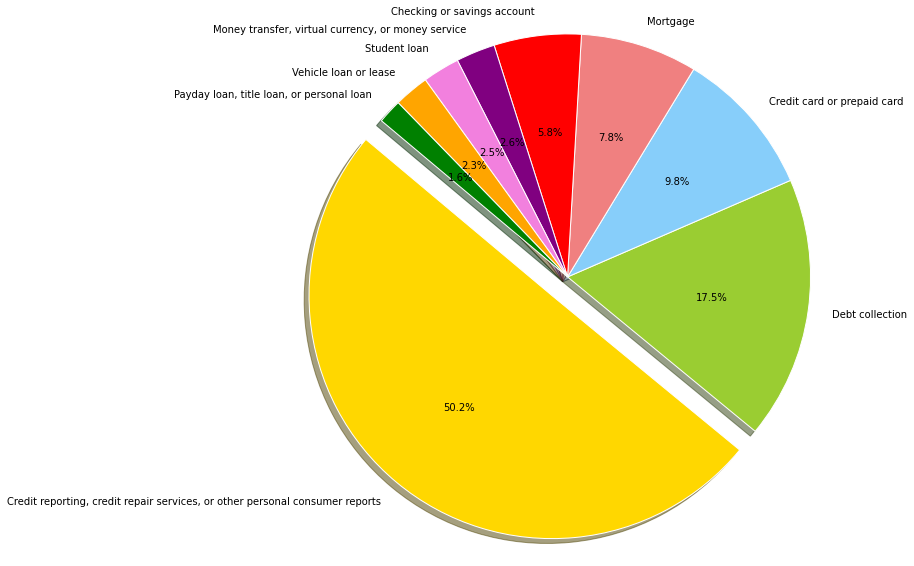

In [45]:
# we visualize the new distibution of our dataset
labels = list(data.Product.value_counts().index)
sizes = list(data.Product.value_counts().values)
colors = ['gold','yellowgreen', 'lightskyblue', 'lightcoral', 'red', 'purple', '#f280de', 'orange', 'green']
explode = (0.1, 0, 0, 0,0,0,0,0,0)  # explode 1st slice

# Plot
plt.figure(figsize=(10,10))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140, wedgeprops={"edgecolor":"white"})
plt.axis('equal')
plt.show()

In [46]:
#we define a function that displays the custumer complaint narrative to have a better idea of text in  order to know how to process it 
def complaint_product(indx,data):
  complaint = data['Consumer complaint narrative'][indx]
  product = data['Product'][indx]
  print(complaint)
  print('------------------------------')
  print("Product : ",product)

In [47]:
complaint_product(238, data)

XXXX XXXX XXXX XXXX is reporting a debt on my credit file that I do not owe. This debt has been paid, and I do not owe this debt and needs to be removed off of my credit.
------------------------------
Product :  Credit reporting, credit repair services, or other personal consumer reports


In [48]:
import string 
#the complaint narrative contains some symboles (XXXXX) to hide the confidential informations such as amount of loan , number of credit card 
#we will delete them 
#we write a funcion to preprocess customer complaint narrative
def clean_text(text):
    '''Make text uppercase(this gonna be the output from speech recognition model which is in uppercase format), remove text in square brackets, remove punctuation, remove words containing numbers, remove stop words and Xs.'''
    text = text.upper()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\n', '', text)
    text = text.replace('X', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

In [49]:
data['Consumer complaint narrative']=data['Consumer complaint narrative'].apply(clean_text)

In [50]:
data

,Product,Consumer complaint narrative
0,"Credit reporting, credit repair services, or o...",I HAVE NOTICED THAT HAVE PLACED AN INQUIRY ON ...
1,"Credit reporting, credit repair services, or o...",THEY REFUSE TO INVESTIGATE DISPUTE BECAUSE THE...
2,"Credit reporting, credit repair services, or o...",THE FOLLOWING COMPANIES RAN UNAUTHORIZED CREDI...
3,Credit card or prepaid card,ON I APPLIED FOR A CITI VISA CARD IN REVIEWING...
4,"Credit reporting, credit repair services, or o...",PULLED MY CREDIT TWICE WITH IN A DAY PERIOD WI...
...,...,...
420612,Credit card or prepaid card,I HAVE AN OVERCHARGE OF ON MY CURRENT BALANCE ...
420613,Debt collection,I PURCHASED A FROM A PERSON WHO SHOWED UP AT M...
420614,"Credit reporting, credit repair services, or o...",ON AN AGREEMENT WAS MADE BETWEEN KOHL S AND MY...
420615,Debt collection,NATIONAL CHECK BUREA AND NEED TO BE PUT OUT OF...


In [51]:
complaint_product(238, data)

IS REPORTING A DEBT ON MY CREDIT FILE THAT I DO NOT OWE THIS DEBT HAS BEEN PAID AND I DO NOT OWE THIS DEBT AND NEEDS TO BE REMOVED OFF OF MY CREDIT
------------------------------
Product :  Credit reporting, credit repair services, or other personal consumer reports


In [52]:
number_words = [len(complaints.split(' ')) for complaints in data["Consumer complaint narrative"]]
len(number_words)

420617

#  Context Classifiction

In [53]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# ech word in the embedding spece is a vector of dimentiality = 100 
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(data['Consumer complaint narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 141340 unique tokens.


In [64]:
#40518 unique words in the text corpus
word_index

{'the': 1,
 'i': 2,
 'to': 3,
 'and': 4,
 'my': 5,
 'a': 6,
 'of': 7,
 'that': 8,
 'on': 9,
 'was': 10,
 'in': 11,
 'this': 12,
 'not': 13,
 'have': 14,
 'credit': 15,
 'they': 16,
 'is': 17,
 'for': 18,
 'me': 19,
 'with': 20,
 'account': 21,
 'it': 22,
 'from': 23,
 'as': 24,
 'be': 25,
 'report': 26,
 'or': 27,
 'information': 28,
 'are': 29,
 'by': 30,
 'had': 31,
 'an': 32,
 'been': 33,
 'them': 34,
 'any': 35,
 'no': 36,
 'you': 37,
 'has': 38,
 'payment': 39,
 'all': 40,
 'reporting': 41,
 'would': 42,
 'at': 43,
 'but': 44,
 'am': 45,
 'debt': 46,
 'which': 47,
 'loan': 48,
 'received': 49,
 'company': 50,
 'bank': 51,
 'did': 52,
 'accounts': 53,
 'we': 54,
 'card': 55,
 'told': 56,
 'were': 57,
 'their': 58,
 'if': 59,
 'these': 60,
 'do': 61,
 'when': 62,
 'so': 63,
 'never': 64,
 'sent': 65,
 'time': 66,
 'consumer': 67,
 'called': 68,
 'because': 69,
 'will': 70,
 'also': 71,
 'after': 72,
 'letter': 73,
 'there': 74,
 'out': 75,
 'payments': 76,
 'can': 77,
 'back': 78,
 

In [55]:
X = tokenizer.texts_to_sequences(data['Consumer complaint narrative'].values)#list of integers that contain the tokens mapped to each word in the text 


In [65]:
X

array([[   0,    0,    0, ..., 4201,   17, 3078],
       [   0,    0,    0, ...,  202,   15,   41],
       [   0,    0,    0, ...,   30, 9102,  420],
       ...,
       [  13,   89,   34, ...,   18,   74,  723],
       [   0,    0,    0, ...,   11,  118, 1543],
       [   0,    0,    0, ...,   83,   12,  212]], dtype=int32)

In [56]:
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH) #padding


In [57]:
print('Shape of data tensor:', X.shape)

Shape of data tensor: (420617, 250)


In [58]:
labels = list(pd.get_dummies(data['Product']).columns)
labels

['Checking or savings account',
 'Credit card or prepaid card',
 'Credit reporting, credit repair services, or other personal consumer reports',
 'Debt collection',
 'Money transfer, virtual currency, or money service',
 'Mortgage',
 'Payday loan, title loan, or personal loan',
 'Student loan',
 'Vehicle loan or lease']

In [59]:
Y = pd.get_dummies(data['Product']).values


In [60]:
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (420617, 9)


In [29]:
X

array([[   0,    0,    0, ..., 4201,   17, 3078],
       [   0,    0,    0, ...,  202,   15,   41],
       [   0,    0,    0, ...,   30, 9102,  420],
       ...,
       [  13,   89,   34, ...,   18,   74,  723],
       [   0,    0,    0, ...,   11,  118, 1543],
       [   0,    0,    0, ...,   83,   12,  212]], dtype=int32)

In [61]:

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(336493, 250) (336493, 9)
(84124, 250) (84124, 9)


In [ ]:
model = Sequential()

#the embedding layer from keras (meme fonctionatilté que word2vec: mapps the word into a vector in the embedding space)
#note: word2vec is trained to extract the relation between words d'une facon general beacause it s trained on the wiki corpus
#while the embedding layer shows the relation between words in the context of this dataset (more specific we can say)
#not the same training algo(the keras embedding layer tries to index a table) 
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(9, activation='softmax'))
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 250, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 9)                 909       
Total params: 5,081,309
Trainable params: 5,081,309
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
epochs = 5
batch_size = 64
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

In [33]:
score=model.evaluate(X_test,Y_test)

print('Test set\n  Loss: {:0.2f}\n  Accuracy: {:0.2f}'.format(score[0],score[1]))

2629/2629 [==============================] - 142s 53ms/step - loss: 0.3228 - accuracy: 0.8921
Test set
  Loss: 0.32
  Accuracy: 0.89


In [66]:
Y_pred = model.predict(X_test)

In [67]:
Y_pred.shape

(84124, 9)

In [68]:
Y_pred

array([[3.28055357e-05, 1.40656804e-04, 1.49246177e-03, ...,
        1.40286866e-03, 1.53271627e-04, 8.68403731e-05],
       [9.29032922e-01, 3.62569913e-02, 1.08995708e-03, ...,
        1.15906051e-03, 1.56695078e-05, 1.04953026e-04],
       [7.15971191e-06, 3.10130235e-05, 9.99722779e-01, ...,
        6.00139401e-07, 4.14641136e-06, 2.11387123e-06],
       ...,
       [3.91665963e-04, 1.21893799e-02, 8.95381033e-01, ...,
        2.24525551e-03, 2.60708411e-03, 4.41061473e-03],
       [8.19087873e-05, 4.38865623e-04, 9.00002360e-01, ...,
        1.23284734e-03, 8.03059414e-02, 6.07974187e-04],
       [1.91879779e-04, 8.53342121e-04, 9.45040762e-01, ...,
        8.75408645e-04, 4.38478921e-04, 5.03679700e-02]], dtype=float32)

In [69]:
predicted_classes = np.argmax(Y_pred, axis=1)

In [70]:
predicted_classes

array([3, 0, 2, ..., 2, 2, 2])

In [72]:
expected_classes =np.argmax(Y_test, axis=1)

#Save model

In [ ]:
import pickle

In [ ]:
model.save("intent_analysis_model.h5")

# Save Modules

In [62]:
import pickle 
with open("tokenizer.pickle","wb") as f :
  pickle.dump(tokenizer,f)

In [63]:
with open("labels.pickle","wb") as f :
  pickle.dump(labels,f)